In [1]:
import torch
from torch import nn 
import numpy as np
import timm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
import os
from tqdm.autonotebook import tqdm
from model.dataloader import SwanDataset, SwanDataLoader
from preprocess.preprocess import basic_preprocess
from albumentations import Resize, Compose, ToFloat
from albumentations.pytorch import ToTensorV2
import sys
import pathlib
import pandas as pd
import wandb
data_path = os.path.join(os.path.dirname(os.getcwd()),'train_dataset_Минприроды')
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

c:\Users\denis\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Не найдена указанная процедура
  warn(f"Failed to load image Python extension: {e}")


In [2]:
model = timm.create_model('mobilevitv2_075.cvnets_in1k', pretrained=True,num_classes=3)

In [3]:
model.get_classifier()

Linear(in_features=384, out_features=3, bias=True)

In [4]:
num_in_feat = model.get_classifier().in_features
model.fc = nn.Sequential(nn.BatchNorm1d(num_in_feat),
                         nn.Linear(in_features=num_in_feat,out_features=512),
                         nn.ReLU(),
                         nn.BatchNorm1d(512),
                         nn.Dropout(0.4),
                         nn.Linear(in_features=512,out_features=3))

In [5]:
# df_description = basic_preprocess(root_dir=data_path)
# merged_data_path = os.path.join(data_path,'Merged\\description.csv')


In [6]:
merged_data_path = os.path.join(data_path,'Merged\\description.csv')
df_description = pd.read_csv(merged_data_path)
df_description.head()

,swan_id,image_name,mask_name
0,0,1.jpg,1.png
1,0,2.jpg,2.png
2,0,3.jpg,3.png
3,0,4.jpg,4.png
4,0,5.jpg,5.png


In [7]:
merged_data_path = os.path.join(data_path,'Merged')
bad_idxs = []
for idxs, file in enumerate(df_description['image_name']):
    path = os.path.join(merged_data_path,'images',file)
    if( not os.path.isfile(path)):
        bad_idxs.append(idxs)
df_description = df_description.drop(bad_idxs)
# df_description = df_description.sample(frac=1).reset_index(drop=True)
df_description.head()


,swan_id,image_name,mask_name
0,0,1.jpg,1.png
1,0,2.jpg,2.png
2,0,3.jpg,3.png
3,0,4.jpg,4.png
4,0,5.jpg,5.png


In [8]:
tr = Compose([
    Resize(256,256),
    ToFloat(),
    ToTensorV2()
])

merged_data_path = os.path.join(data_path,'Merged')

train_df,test_df = train_test_split(df_description,test_size=0.2)


In [9]:
train_swans = SwanDataset(merged_data_path,description_df=train_df,transforms=tr)
test_swans = SwanDataset(merged_data_path,description_df=test_df,transforms=tr)

train_dataloader = SwanDataLoader(train_swans,batch_size=16,shuffle=True)
test_dataloader = SwanDataLoader(test_swans,batch_size=16,shuffle=True)

In [10]:
def train(model,train_dataloader,test_dataloader,optimizer,criterion,device,epochs=1):

    avg_loss_history_train = []
    accuracy_train_history = []

    avg_loss_history_test = []
    accuracy_test_history = []
    
    last_train_preds = []
    last_train_truths = []
    last_test_preds = []
    last_test_truths = []

    for i in tqdm(range(epochs)):

        model.train()

        train_batch_loss_history = []
        epoch_loss_train = 0

        preds_train = []
        truths_train = []

        

        for data in tqdm(train_dataloader):
            imgs,_,labels = data
            imgs = imgs.to(device)
            labels = labels.to(device)

            outs = model(imgs)

            

            loss = criterion(outs,labels)

            preds_train.extend(outs.argmax(1).tolist())
            truths_train.extend(labels.tolist())
            
            # print(preds_train[-1],truths_train[-1])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            wandb.log({
                 'train batch loss' : loss.item()
            })
            epoch_loss_train += loss.item()

            train_batch_loss_history.append(loss.item())

        
        accuracy_train = accuracy_score(truths_train,preds_train)
        accuracy_train_history.append(accuracy_train)

        wandb.log({
            'avg train loss on epoch': epoch_loss_train / len(train_dataloader),
            'accuracy train' : accuracy_train
        })
        
        avg_batch_loss_train = np.mean(train_batch_loss_history)

        print(f'Loss on epoch train = {avg_batch_loss_train}')
        print(f'Total Accuracy train: {accuracy_train}')

        avg_loss_history_train.append(avg_batch_loss_train)
        torch.save(
             {
                  'train_loss' : avg_loss_history_train[-1],
                  'state_dict' : model.state_dict() 
             },
             f'./checkpoints/{i}.pt'
        )

        with torch.no_grad():
            model.eval()

            preds_test = []
            truths_test = []

            testbatch_loss_history = []
            epoch_loss_test= 0

            for data in tqdm(test_dataloader):
                    imgs,_,labels = data
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                    outs = model(imgs)
                    

                    loss = criterion(outs,labels)
                    
                    wandb.log({
                            'test batch loss' : loss.item()
                    })
                    preds_test.extend(outs.argmax(1).tolist())
                    truths_test.extend(labels.tolist())

                    epoch_loss_test += loss.item()

                    testbatch_loss_history.append(loss.item())

            
            accuracy_test = accuracy_score(truths_test,preds_test)
            accuracy_test_history.append(accuracy_train)

            wandb.log({
                'avg test loss on epoch': epoch_loss_test / len(test_dataloader),
                'accuracy test' : accuracy_test
            })
            
            avg_batch_loss_test = np.mean(testbatch_loss_history)

            print(f'Loss on epoch test= {avg_batch_loss_test}')
            print(f'Total Accuracy test: {accuracy_test}')

            avg_loss_history_test.append(avg_batch_loss_test)
        
        last_train_preds = preds_train
        last_train_truths = truths_train
        last_test_preds = preds_test
        last_test_truths = truths_test

    return (avg_loss_history_train,accuracy_train_history,avg_loss_history_test,accuracy_test_history,
            last_train_preds,last_train_truths,last_test_preds,last_test_truths)

In [11]:
lr = 1e-4
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=lr)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
epochs = 10

In [12]:
run = wandb.init(
    project='hackathon',
    config={
        'learning_rate' : lr,
        'epochs': epochs
    },
)

results = train(model,train_dataloader,test_dataloader,optimizer=opt,criterion=criterion,device=device,epochs=epochs)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lone_wayfarer (dl_sk23). Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

Loss on epoch train = 0.6534082738732079
Total Accuracy train: 0.7419042347079989


  0%|          | 0/113 [00:00<?, ?it/s]

Loss on epoch test= 0.2641753502585719
Total Accuracy test: 0.9064748201438849


  0%|          | 0/452 [00:00<?, ?it/s]

Loss on epoch train = 0.24463703946119783
Total Accuracy train: 0.9135067810683642


  0%|          | 0/113 [00:00<?, ?it/s]

Loss on epoch test= 0.21282465657037972
Total Accuracy test: 0.9252905368013282


  0%|          | 0/452 [00:00<?, ?it/s]

Loss on epoch train = 0.1689700951214583
Total Accuracy train: 0.943260448380847


  0%|          | 0/113 [00:00<?, ?it/s]

Loss on epoch test= 0.19777044362133056
Total Accuracy test: 0.9263973436635307


  0%|          | 0/452 [00:00<?, ?it/s]

Loss on epoch train = 0.12110507227810083
Total Accuracy train: 0.9606974813174647


  0%|          | 0/113 [00:00<?, ?it/s]

Loss on epoch test= 0.1908510622271724
Total Accuracy test: 0.9380188157166575


  0%|          | 0/452 [00:00<?, ?it/s]

Loss on epoch train = 0.08802190783075098
Total Accuracy train: 0.9696927760863548


  0%|          | 0/113 [00:00<?, ?it/s]

Loss on epoch test= 0.1769639883546851
Total Accuracy test: 0.9407858328721638


  0%|          | 0/452 [00:00<?, ?it/s]

Loss on epoch train = 0.06868869124136998
Total Accuracy train: 0.9773041793523388


  0%|          | 0/113 [00:00<?, ?it/s]

Loss on epoch test= 0.22887191532872023
Total Accuracy test: 0.9341449916989485


  0%|          | 0/452 [00:00<?, ?it/s]

Loss on epoch train = 0.0456667303576946
Total Accuracy train: 0.9858843066703571


  0%|          | 0/113 [00:00<?, ?it/s]

Loss on epoch test= 0.23507388388589684
Total Accuracy test: 0.9374654122855561


  0%|          | 0/452 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
best_state = torch.load('./checkpoints/4.pt')

In [16]:
model = timm.create_model('mobilevitv2_075.cvnets_in1k', pretrained=True,num_classes=3)
model.get_classifier()
num_in_feat = model.get_classifier().in_features
model.fc = nn.Sequential(nn.BatchNorm1d(num_in_feat),
                         nn.Linear(in_features=num_in_feat,out_features=512),
                         nn.ReLU(),
                         nn.BatchNorm1d(512),
                         nn.Dropout(0.4),
                         nn.Linear(in_features=512,out_features=3))

In [27]:
model.load_state_dict(best_state['state_dict'])
model = model.to('cuda')


In [32]:
def calculate_model_perfomance(model, val_loader):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    preds = []
    truths = []
    with torch.no_grad():
        for data in tqdm(val_loader):
            imgs,_,labels = data
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outs = model(imgs)


            preds.extend(outs.argmax(1).tolist())
            truths.extend(labels.tolist())

                    
    return preds, truths

In [33]:
y_train_preds, y_train_true = calculate_model_perfomance(model,train_dataloader)
y_test_preds, y_test_true = calculate_model_perfomance(model,test_dataloader)


  0%|          | 0/452 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

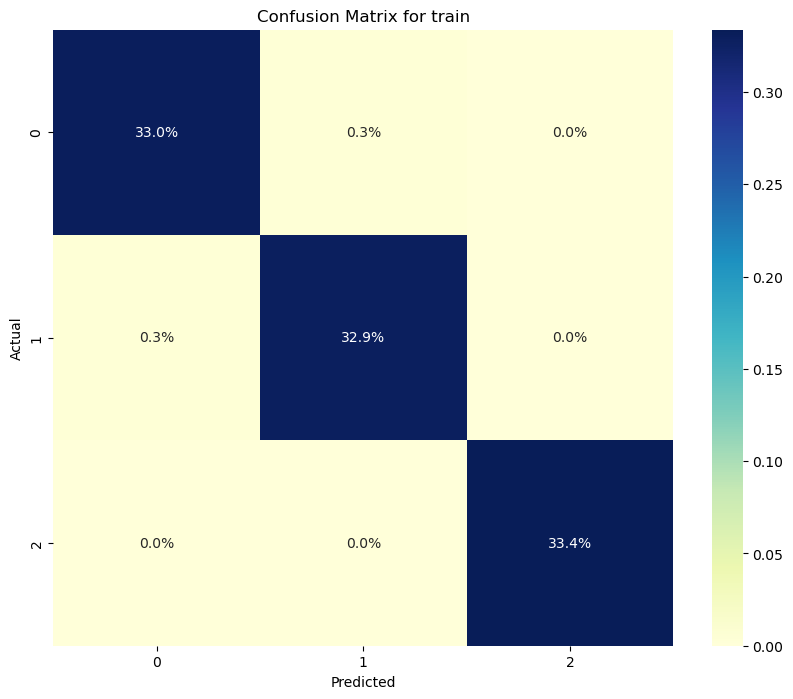

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train_true,y_train_preds)


# Plot confusion matrix
plt.figure(figsize=(10,8))

b = sns.heatmap(cm/np.sum(cm),annot=True,fmt='.1%',cmap='YlGnBu')
b.set(title='Confusion Matrix for train')
b.set(xlabel='Predicted',ylabel='Actual')

plt.show()

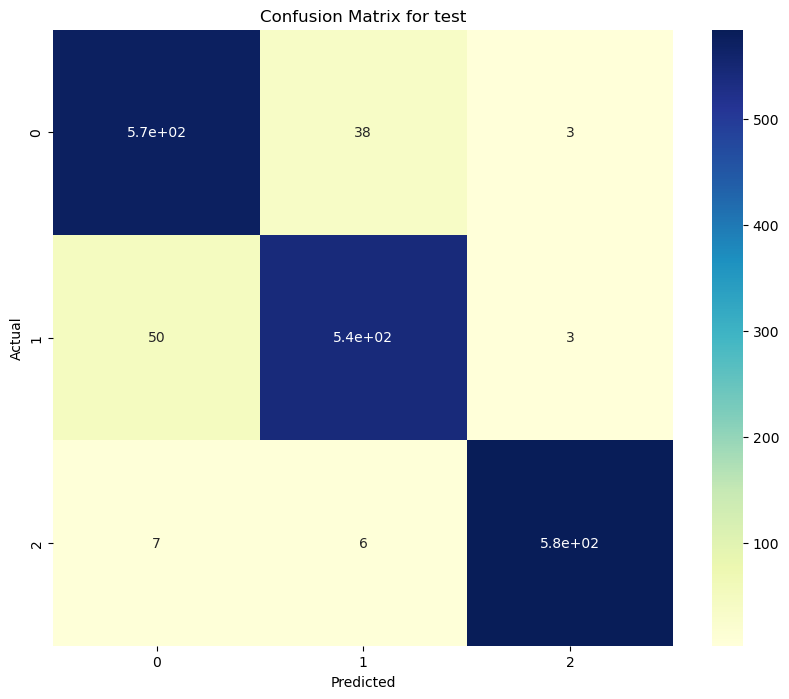

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_true,y_test_preds)


# Plot confusion matrix
plt.figure(figsize=(10,8))

b = sns.heatmap(cm,annot=True,cmap='YlGnBu')
b.set(title='Confusion Matrix for test')
b.set(xlabel='Predicted',ylabel='Actual')

plt.show()

In [45]:
best_state = torch.load('./checkpoints/best.pt')
best_state_dict = best_state['state_dict']
torch.save(best_state_dict,'./checkpoints/best.pt')

In [ ]:
model = timm.create_model('mobilevitv2_075.cvnets_in1k', pretrained=True,num_classes=3)

num_in_feat = model.get_classifier().in_features
model.fc = nn.Sequential(nn.BatchNorm1d(num_in_feat),
                         nn.Linear(in_features=num_in_feat,out_features=512),
                         nn.ReLU(),
                         nn.BatchNorm1d(512),
                         nn.Dropout(0.4),
                         nn.Linear(in_features=512,out_features=3))